In [2]:
# general imports
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
import seaborn as sns


# vectorizer that will be used later
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import collections

# Key skills extraction with Topic Modelling (LDA, NMF) an exploration with `gensim`, `nltk`, and `sklearn`
* A lot of the code that I have been using is through my past experiences and resources I found online. Please have a quick look of my github if interested.
* [Github](https://github.com/ChiWang03)
* [Text Classification](https://github.com/ChiWang03/Text-Classification/blob/master/Code/Classifier/Classifiers/Consumption%20Classifier.ipynb)
* [App review Analysis](https://github.com/ChiWang03/App-Review-Analysis/blob/master/Topic_Modelling_by_year.ipynb)


In [3]:
# import data
df = pd.read_csv('job_postings.csv')
df.head()

,Job Title,Description,Location,url
0,Machine Learning Engineer / Data Scientist,The OpportunityDo you enjoy solving complex pr...,Vancouver,https://ca.indeed.com/pagead/clk?mo=r&ad=-6NYl...
1,Elementary & High School Math and Science Tuto...,STEM is in and so are you! Tutor Doctor – the ...,Vancouver,https://ca.indeed.com/pagead/clk?mo=r&ad=-6NYl...
2,Payroll Specialist,Job SummaryThe Payroll Specialist performs acc...,Vancouver,https://ca.indeed.com/pagead/clk?mo=r&ad=-6NYl...
3,Data Integrity Senior Associate,About adMare\n\nadMare BioInnovations is a pan...,Vancouver,https://ca.indeed.com/pagead/clk?mo=r&ad=-6NYl...
4,Data Scientist 3 - (13828) Vancouver,This is a 6 month contract position. The locat...,Vancouver,https://ca.indeed.com/pagead/clk?mo=r&ad=-6NYl...


# Cleaning the data set

## Remove duplicates
* We know that it is likely to have duplicates since I searched for both data scientist and machine learning engineer in the same city.
* This is why we would drop duplicates based on the url, url is unique unlike most of the columns.

In [4]:
df.head()

,Job Title,Description,Location,url
0,Machine Learning Engineer / Data Scientist,The OpportunityDo you enjoy solving complex pr...,Vancouver,https://ca.indeed.com/pagead/clk?mo=r&ad=-6NYl...
1,Elementary & High School Math and Science Tuto...,STEM is in and so are you! Tutor Doctor – the ...,Vancouver,https://ca.indeed.com/pagead/clk?mo=r&ad=-6NYl...
2,Payroll Specialist,Job SummaryThe Payroll Specialist performs acc...,Vancouver,https://ca.indeed.com/pagead/clk?mo=r&ad=-6NYl...
3,Data Integrity Senior Associate,About adMare\n\nadMare BioInnovations is a pan...,Vancouver,https://ca.indeed.com/pagead/clk?mo=r&ad=-6NYl...
4,Data Scientist 3 - (13828) Vancouver,This is a 6 month contract position. The locat...,Vancouver,https://ca.indeed.com/pagead/clk?mo=r&ad=-6NYl...


In [5]:
print('The total number of rows in the scraped job post data ', len(df))

The total number of rows in the scraped job post data  1615


In [6]:
# drop duplicates 
df = df.drop_duplicates(['Location', 'url'], keep= 'first')
df = df.reset_index(inplace = False, drop = True)
# keep = 'first' the first one seen in the table when a duplicate is found 
print('After dropping duplicates we have '+ str(len(df))+' rows')

# now compared to the old data frame we dropped 1615-1541 = 74 rows that are duplicated

After dropping duplicates we have 1541 rows


## Removing irrelevant jobs
* Irrelevant job posts exist because there are some sponsored job postings and job postings in similar fields that can be mistaken by the Indeed search engine.
* Take a look at the example below `Elementary & High School Math and Science Tutors`, I think this was included in the search results because people with data science background are good at math and science. However, this is a irrelvant job post that needs to be removed from the data set.

In [7]:
df['Job Title'][1]

'Elementary & High School Math and Science Tutors (TDBC-05)'

## How do we remove irrelavant jobs?
* Lets try to remove by keepinng only records with Job Titles that contains the word `Data` or `Machine` 

In [8]:
# lower case the job title since if we check contains some string it is case sensitive
df['Job Title'] = df['Job Title'].str.lower()

In [9]:
df = df[((df['Job Title'].str.contains('data', na = False)) | (df['Job Title'].str.contains('machine', na = False)))]
df = df.reset_index(inplace = False, drop = True)
print(len(df))
#df.head()

566


### Now that we have filtered out Job Titles that don't contain `data or machine`  there is only 566 records left in the data set.

# How will we find the key/critical skills in this data set? 

### My suggestion is to perform some sort of Topic Modelling method. Some popular Topic modelling methods could be used such as LDA, NMF, LSA etc.

### We will perform LDA and NMF first and see how it goes. I've previously used multiple libraries to perform topic modelling such as `gensim` and `sklearn`. Most of my past experience tell me that gensim performs better, and that for smaller data sets NMF may perform better than LDA. However, this really depends on the data set. 

### Steps:
1. preprocess data (vectorizing text)
2. observe the most frequent words to get an idea of the data set and possible key skills
3. perform `lda` with `sklearn` using both tfidfvectorizer and countvectorizer (will be summarized in the end)
4. pefrom `lda` with `gensim` (Usually better performance but for larger data sets)
5. perform `NMF` (usually good with smaller data sets and shorter texts)
6. Conclusions (summarzing topics and discussing key skills)

### Some pitfalls to remember before proceeding. 
* It is very important to know that 566 text documents is not enough data and we dont expect good results. I will try my best to extract some meaning out of the topics produced.

* Also be aware that the number of words in the description is quite short. Usually short text Topic Modelling doesn't perform well as well. We will evaluate the performance by using Coherence scores lets get started with preprocessing! 

## 1. Preprocessing
* I have previously done some topic modelling and did a lot of research on the best ways to preprocess data such as debating which stemmer to use or whether to stem or lemmatize. 
* In my opinion, in order to truthfully represent the data it is best to lemmatize the text document. 
* What is a good way to lemmatize? I personally like the use of `pos tagging` in `nltk`, but I have heard that `spacy` is an excellent library that is up to date with the industry in terms of natural language processing. 

## Steps:
1. lowercase text
2. remove non ascii
3. remove stop words
4. lemmatize (Part of Speech Tagging)

# Quick Guide: Lemmatization vs Stemming 

In [10]:
# gensim imports for preprocessing
import gensim
import nltk
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer, SnowballStemmer


# Using POS Tag to lemmatize
from nltk.corpus import wordnet

### Stemming normalizes words into its base form while lemmatization is the same but considers the context and converts the word to a meaningful base word. Lemmatization with part of speech tagging makes it even more accurate.
* If we compare the results of lemmatization and stemming below we see that when we lemmatize the word `computation`, it will still be `computation` but when we stem the word it becomes `comput`
* In this example we see another very bad scenario where if we lemmatize `computation` and `computer` they will both stay in its original form. However, if we stem the two words they will both turn into `comput`. We know that there is quite some difference between `computation` and `computer` and that stemming turns them into the same words `comput`. This is inaccurately representing the data.

### The example below shows us why we lemmatize and not stem. It is likely that stemming gives better results in terms of text classification, but what we are trying to do now is more of understanding the text and topics so lets avoid stemming. 

In [11]:
# when lemmatizing computation => computation
WordNetLemmatizer().lemmatize("computation", pos='n')

'computation'

In [12]:
# when lemmatizing computer => computer
WordNetLemmatizer().lemmatize("computer", pos='n')

'computer'

In [13]:
# when stemming computation => comput
SnowballStemmer('english').stem("computation")

'comput'

In [14]:
# when stemming computer => comput 
SnowballStemmer('english').stem("computer")

'comput'

### I have noticed that when we are looking for data scientist key skills it is very likely that they are phrases and not single words.  Most key skills that we commonly know of that is related to data scientists are skills such as `machine learning, deep learning, neural networks, and natural language processing` these are not single words, but phrases. This is why when we perform topic modelling we must include bigrams and trigrams in the vectorization steps for a better representation of key skills. 

### After understanding this situation it is not as necessary to work with gensim. As the reason is no bigrams nor trigrams are likely to be generated. For the gensim phraser to work the text data has to be huge. Because it works on basis of counts of phrases. So this limitation leads us to a new phraser identifier which would be done with the `nltk` library `CountVectorizer` and `TfidfVectorizer`.  But lets take a look anyway.

# Preprocessing function
* contains lemmatization with pos tagging
* remove non ascii and stop words


In [15]:
# Using POS Tag to lemmatize
from nltk.corpus import wordnet

# get pos tag for lemmetization
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# remove wnon ascii characters
def is_ascii(s):
    return all(ord(c) < 128 for c in s)

stop_words = gensim.parsing.preprocessing.STOPWORDS 
# We considred using a stemmer, but since we have the pos tags 
# creating a more accuracte lemmatizer we will not go down that process
# better and newwer stemmer than porterstemmer 
stemmer = SnowballStemmer('english')
# stemmer only used for example and comparison between stemmning and lemmatizing in notebook

# wrap everything in a preprocessing_text function
def preprocess_text(text):
    processed = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stop_words  and len(token) > 3 and is_ascii(token) == True:
            processed.append(WordNetLemmatizer().lemmatize(token, pos = get_wordnet_pos(token)))
    return processed

In [16]:
# preprocess the description and rename it to processed description

df['Processed Description'] = df['Description'].map(preprocess_text)

# After preprocessing the description is in the form of a list. 

In [17]:
print(df['Processed Description'][10])

['company', 'maritime', 'employer', 'association', 'industry', 'data', 'analytics', 'level', 'time', 'location', 'vancouver', 'compensation', 'salary', 'benefit', 'overview', 'support', 'position', 'critical', 'support', 'ongoing', 'development', 'bcmea', 'analytics', 'program', 'push', 'program', 'level', 'support', 'bcmea', 'long', 'term', 'strategic', 'initiative', 'creative', 'require', 'business', 'orient', 'creative', 'inquisitive', 'passionate', 'organize', 'professional', 'strong', 'quantitative', 'background', 'recent', 'professional', 'experience', 'data', 'science', 'collaborate', 'work', 'collaboratively', 'bcmea', 'programmer', 'developer', 'implement', 'conceptualize', 'data', 'pipeline', 'feed', 'model', 'result', 'tableau', 'server', 'bcmea', 'website', 'helm', 'analysis', 'support', 'continued', 'curation', 'bcmea', 'analytics', 'report', 'expand', 'portfolio', 'bcmea', 'analytics', 'report', 'driven', 'demand', 'push', 'candidate', 'bcmea', 'resource', 'act', 'primary

In [18]:
# Quick look at the average length of the processed description text document 
descrip_length = []
for text in df['Processed Description']: 
    descrip_length.append(len(text))
df['Document length']  = descrip_length 
df['Document length'].mean()

346.42402826855124

### Notice that there is on average 350 words in each Data Scientist related Job Posting after preprocessing
* This is considered a short text document and generally won't perform well with Topic modelling methods. We can see this with the coherence scores later. 

## Observe the most frequent/Common phrases utilizing the TfidfVectorizer and CountVectorizer in `sklearn` with different ngrams. 


## Most frequent phrases using TfidfVectorizer with Bigrams and Trigrams

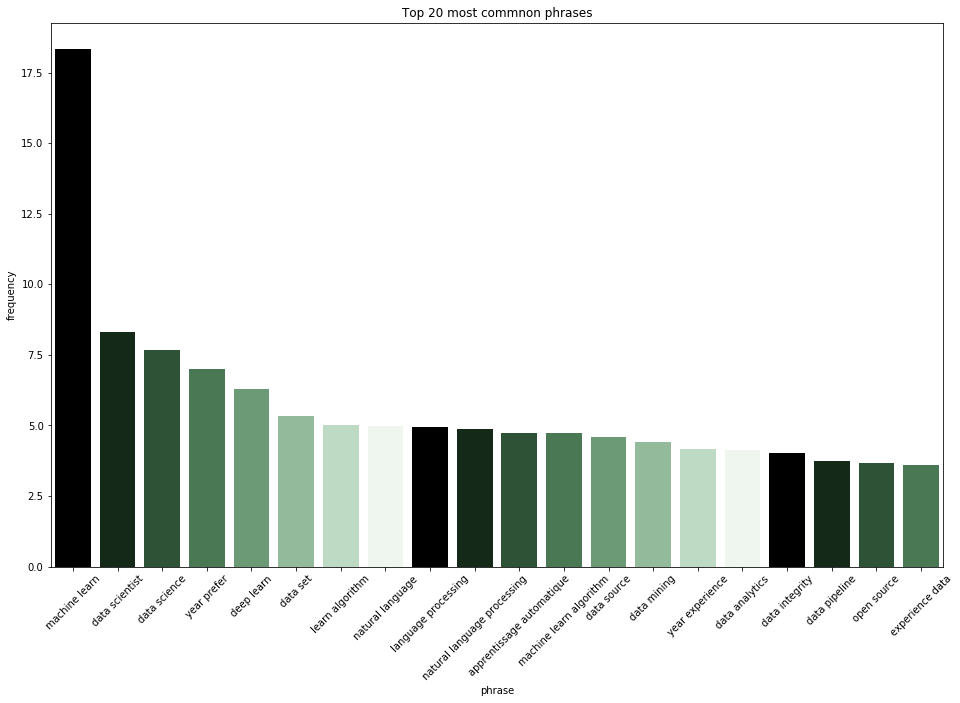

In [19]:
# Let's turn the list into a string 
df['processed_string'] =  [' '.join(words) for words in df['Processed Description']]


tfidf = TfidfVectorizer(ngram_range = (2, 3))
description = df['processed_string']

bagofwords_description = tfidf.fit_transform(description)
freq_description = dict(zip(tfidf.get_feature_names(), np.asarray(bagofwords_description.sum(axis=0)).ravel()))
count_description = pd.DataFrame(collections.Counter(freq_description).most_common(20), columns = ['phrase', 'frequency'])

fig, ax = plt.subplots(figsize=(16, 10))
colour = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True)
g = sns.barplot(x="phrase", y='frequency', data=count_description, palette=colour, ax=ax)
loc, labels = plt.xticks()
plt.title('Top 20 most commnon phrases')
g.set_xticklabels(labels, rotation=45)
plt.show();

## CountVectorizer Bigrams and Trigrams 

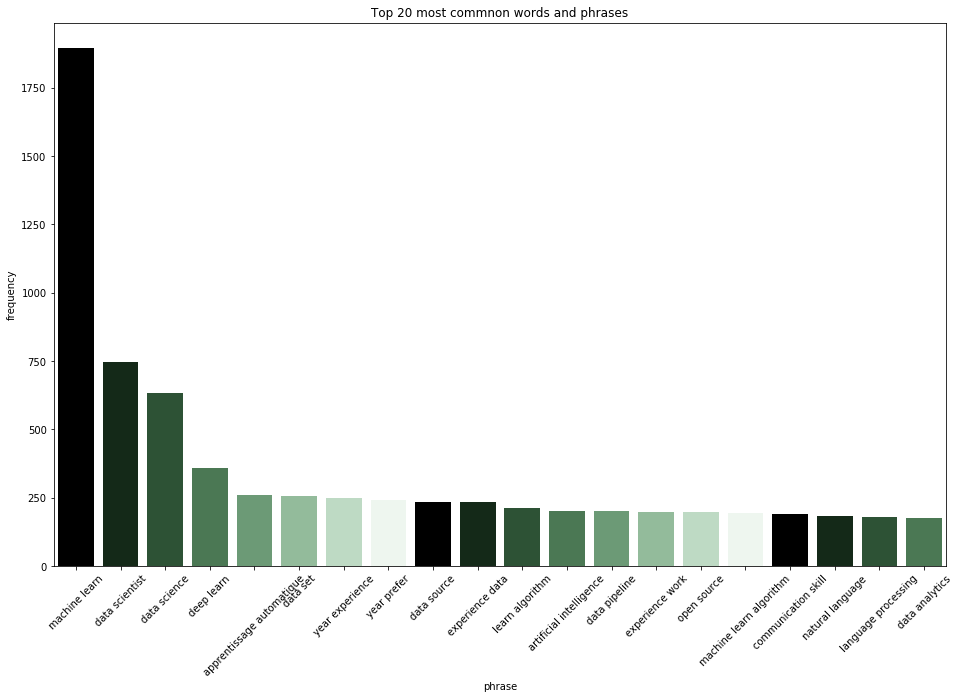

In [20]:
cv= CountVectorizer(ngram_range = (2, 3))
description = df['processed_string']

bagofwords_description = cv.fit_transform(description)
freq_description = dict(zip(cv.get_feature_names(), np.asarray(bagofwords_description.sum(axis=0)).ravel()))
count_description = pd.DataFrame(collections.Counter(freq_description).most_common(20), columns = ['phrase', 'frequency'])

fig, ax = plt.subplots(figsize=(16, 10))
colour = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True)
g = sns.barplot(x="phrase", y='frequency', data=count_description, palette=colour, ax=ax)
loc, labels = plt.xticks()
plt.title('Top 20 most commnon words and phrases')
g.set_xticklabels(labels, rotation=45)
plt.show();

# CountVectorizer with trigrams and quadgrams

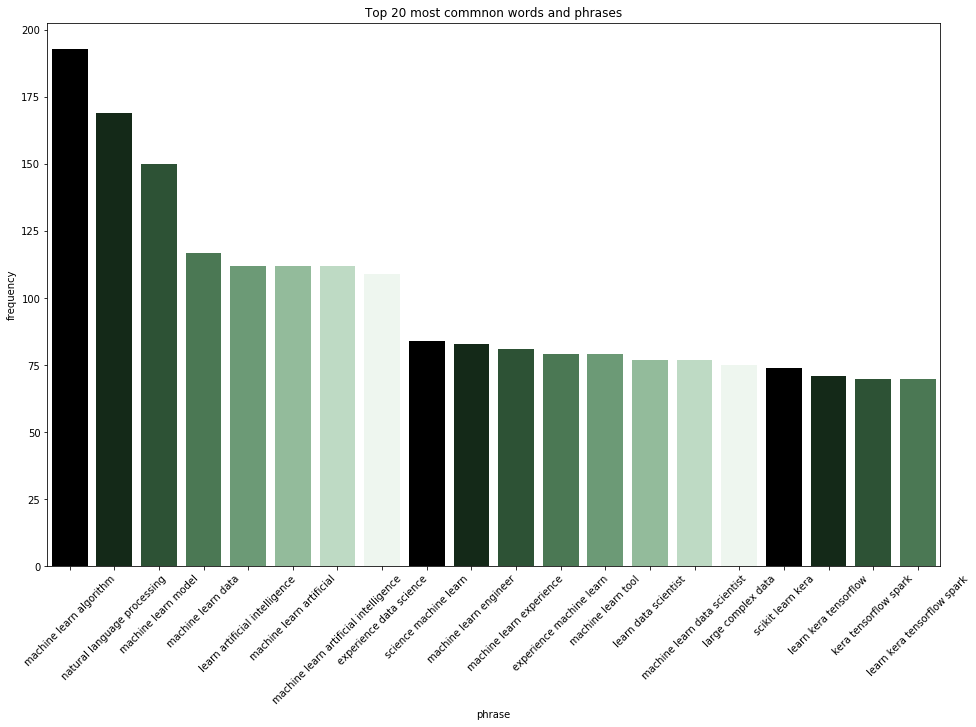

In [21]:
cv= CountVectorizer(ngram_range = (3, 4))
description = df['processed_string']

bagofwords_description = cv.fit_transform(description)
freq_description = dict(zip(cv.get_feature_names(), np.asarray(bagofwords_description.sum(axis=0)).ravel()))
count_description = pd.DataFrame(collections.Counter(freq_description).most_common(20), columns = ['phrase', 'frequency'])

fig, ax = plt.subplots(figsize=(16, 10))
colour = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True)
g = sns.barplot(x="phrase", y='frequency', data=count_description, palette=colour, ax=ax)
loc, labels = plt.xticks()
plt.title('Top 20 most commnon words and phrases')
g.set_xticklabels(labels, rotation=45)
plt.show();

# What do we observe from the most common phrases? 

* summarizing the above 3 bar plots we can say that probably the more important skills are 
    * Technical skills
        * deep learning
        * software development
        * Algorithm
        * machine learning algorithms
        * natural language processing
        * machine learning models   
        * Artificial Intelligence
        * kera, tensorflow, spark
        * scikit learn
        * data pipeline
        * data analytics
 
    * other skills/ soft skills
        * writing communication skills
        * problem solving
        * being cross functional
        * being up to date with cutting edge/ state of the art machine learning technology
        
### Note that I did not show tfidfvectorizer with trigrams and quandgrams because the most frequent words were not as meaningful. Understanding the most common/frequent phrases using the two different vectorizers don't necessarily mean much, but gives us an idea of what's happening in our data. I believe the portrayal of common phrases with a bar plot is more easily understood than a word cloud. 
`    

# Topic Modelling 
# Important Note: There is no need to read all the topics that are printed out by the models, I will summarzie at the very end, thank you!

## LDA with Sklearn 
* now after looking at the multiple ways of vectorizing text using either tfidf and countvectorizer with ngrams we have to decide which one to be used in the model.

## Lets test out LDA using `TfidfVectorizer(ngram_range = (2, 3))` first and later test out  `CountVectorizer(ngram_range = (2, 3))` and see which method produces more meaningful topics

In [21]:
# Using TfidfVectorizer(ngram_range = (2, 3))

from sklearn.decomposition import LatentDirichletAllocation

# vectorize text using tfidf bigrams and trigrams 
tfidf = TfidfVectorizer(ngram_range = (2, 3))
description = df['processed_string']

bagofwords_description = tfidf.fit_transform(description)

features = tfidf.get_feature_names()

# we suggest that there are 25 topics since later we will see that gensim lda mallet tells us that 
# based on the coherence scores 25 topics best represent this data set

lda_tfidf = LatentDirichletAllocation(n_components=25, max_iter=5, learning_method='online', learning_offset=50.,random_state=3).fit(bagofwords_description)

# print topic funciton
def print_topics(model, feature_names, top_words):
    for idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (idx))  
        print (", ".join([feature_names[i] for i in topic.argsort()[:-top_words - 1:-1]]))
        print( "\n")

# print topics
print_topics(lda_tfidf, features, 10)

Topic 0:
machine learn, mobile platform, develop scale, signal processing, field develop scale, communication domain, field develop, unsupervised learn, engineering knowledge, platform mobile


Topic 1:
machine learn, natural language, natural language processing, language processing role, classification cluster natural, collection feedback, objective collaborate project, language processing, mechanism automate, data year experience


Topic 2:
application consider, tech role, lead company, company prime, smart city, work excite, junior data scientist, junior data, reach opportunity match, lead company match


Topic 3:
machine learn, portfolio company, language english, require language english, language english require, linear algebra calculus, learn algorithm, skill english, work smart passionate, http github


Topic 4:
apprentissage automatique, machine learn, dans domaine, data scientist, open source, experience data science, data science, experience data, global team, entreprises e

In [36]:
# Using TfidfVectorizer(ngram_range = (2, 3))

from sklearn.decomposition import LatentDirichletAllocation

# vectorize text using tfidf bigrams and trigrams 
cv= CountVectorizer(ngram_range = (2, 3))
description = df['processed_string']

bagofwords_description = cv.fit_transform(description)

features = cv.get_feature_names()

# we suggest that there are 25 topics since later we will see that gensim lda mallet tells us that 
# based on the coherence scores 25 topics best represent this data set

lda_count = LatentDirichletAllocation(n_components=25, max_iter=5, learning_method='online', learning_offset=50.,random_state=3).fit(bagofwords_description)

# print topics 
print_topics(lda_count, features, 10)

Topic 0:
machine learn, university calgary, postdoctoral scholar, quantum compute, data scientist, data science, real time, software developer, work closely, industry lead


Topic 1:
machine learn, data science, data scientist, year experience, deep learn, software development, experience work, degree science, data pipeline, year require


Topic 2:
machine learn, operator responsible, team member, work support, duty assign, integrate lean sigma, integrate lean, future snack, drive performance, lead future snack


Topic 3:
data analysis, data science, team member, machine learn, equal opportunity employer, opportunity employer, equal opportunity, critical think, join team, location location


Topic 4:
machine learn, underground navigation, data science, portfolio company, data scientist, master degree, degree require, navigation work, master degree require, language english


Topic 5:
mobile growth, analytics team, customer behavior, growth analytics, well understand, mobile growth anal

## Let's try `Gensim`'s `LDA Mallet` one of the better built LDA libraries
### As mentioned above gensim phraser has problems with small data sets and it is clearly seen in the topics below. Most topics have single words associated with it and we want bigrams or trigrams. The only trigram that is seen is `natural language processing` and that is not enough.

### I suggest only using Gensim's LDA Mallet to understand the optimal number of topics that gives the highest coherence value


### Setup bigrams trigrams and build Corpus

In [23]:
import gensim

import gensim.corpora as corpora

bigram = gensim.models.phrases.Phraser(gensim.models.Phrases(df['Processed Description'].tolist(),
                                                                     min_count=1,
                                                                     threshold=100))

trigram = gensim.models.phrases.Phraser(gensim.models.Phrases(bigram[df['Processed Description'].tolist()],
                                                                      threshold=100))

bigrams = [bigram[phrase] for phrase in df['Processed Description'].tolist()]
trigrams = [trigram[bigram[phrase]] for phrase in df['Processed Description'].tolist()]



dictionary = corpora.Dictionary(trigrams)
# keep only the terms that appear more than 3 times and only the top 10000
dictionary.filter_extremes(no_above = 3, no_below = 0.1, keep_n = 10000)
document =trigrams

corpus = [dictionary.doc2bow(text) for text in document]

In [24]:
import os
from gensim.models.wrappers import LdaMallet
from gensim.models import CoherenceModel
coherence_scores = []


# since we want to know the coherence of different topics lets write a loop to iterate to the multiple topics 
topics  = [5,10,15,20,25,30]

for i in topics:
    mallet = gensim.models.wrappers.LdaMallet('/Users/chi/desktop/webscraper/mallet-2.0.8/bin/mallet', 
                                              corpus=corpus, 
                                              num_topics=i,
                                              id2word=dictionary,
                                              workers = 4,random_seed = 2013)
    coherence_mallet = CoherenceModel(model=mallet, texts=document, dictionary=dictionary, coherence='c_v').get_coherence()
    coherence_scores.append(coherence_mallet)

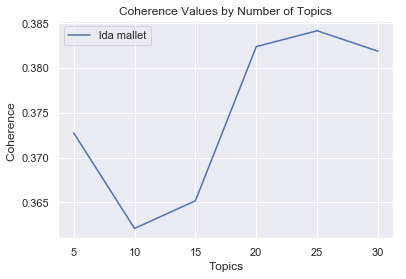

In [25]:
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import seaborn as sns; sns.set()
topics  = [5,10,15,20,25,30]

palette = dict(zip([1,2],sns.color_palette("nipy_spectral_r", 4)))

ax1 = sns.lineplot(topics ,coherence_scores, palette = palette, label = "lda mallet")

ax1.set(xlabel ='Topics')
ax1.set(ylabel = 'Coherence ')
ax1.set_title('Coherence Values by Number of Topics')
leg =ax1.legend()

plt.show()

### We see that coherence peaks at 25 topics so we will use 25 topics to represent the data. Also note that the coherence score 0.385 is quite low. I've previously worked with a data set that had 400,000 records and the coherence score was much higher (around 0.6). This shows that the data collection is flawed and may affect the understanding of the topics. However, we will proceed and try to extract as much information as we could. 


# Observing the topics produced by LDA Mallet

* I don't think it is quite clear to me what each topic represents. In addition, I also looked into the text documents that are highly associated with each topic. It was not direct and clear to me what each topic was trying to convey. This is most likely because single words without the use of bigrams or trigrams limits the understanding of the topics. Compared to the other topics generated by lda in sklearn 

# The bottom output of lda mallet topics may be ignored. It is not a good representation of topic and I left it there as a reference. Topics make more sense when more bigrams and trigrams are involved.

In [26]:
optimal_topics_lda = gensim.models.wrappers.LdaMallet('/Users/chi/desktop/webscraper/mallet-2.0.8/bin/mallet', 
                                              corpus=corpus, 
                                              num_topics=25,
                                              id2word=dictionary,
                                              workers = 4,random_seed = 2013)

for idx, topic in optimal_topics_lda.print_topics(-1):
    print('Topic: {} \nWords: {} \n'.format(idx, topic))

Topic: 0 
Words: 0.043*"work" + 0.028*"team" + 0.022*"canada" + 0.021*"product" + 0.020*"company" + 0.015*"data" + 0.013*"insurance" + 0.012*"grow" + 0.012*"culture" + 0.011*"analysis" 

Topic: 1 
Words: 0.038*"team" + 0.027*"skill" + 0.027*"role" + 0.025*"lead" + 0.023*"company" + 0.020*"mobile" + 0.016*"experience" + 0.015*"technology" + 0.014*"communication" + 0.014*"customer" 

Topic: 2 
Words: 0.062*"learn" + 0.044*"algorithm" + 0.042*"work" + 0.040*"machine" + 0.033*"team" + 0.023*"experience" + 0.020*"design" + 0.020*"vision" + 0.020*"implement" + 0.020*"high" 

Topic: 3 
Words: 0.044*"learn" + 0.043*"team" + 0.043*"work" + 0.024*"machine" + 0.023*"engineer" + 0.022*"building" + 0.017*"problem" + 0.017*"skill" + 0.016*"build" + 0.016*"experience" 

Topic: 4 
Words: 0.027*"work" + 0.017*"opportunity" + 0.016*"employee" + 0.011*"community" + 0.011*"benefit" + 0.010*"montreal" + 0.010*"diverse" + 0.009*"environment" + 0.009*"canada" + 0.009*"commit" 

Topic: 5 
Words: 0.066*"techno

# NMF
### NMF (Nonnegative Matrix Factorization) in sklearn. 
### NMF performs rather differently than LDA. LDA is probabilitic while NMF relies on decomposition of a matrix into two Nonnegative matrices (relies heavily on linear algebra). 


* I will only test out TfidfVectorizer, different vectorizers can be test for further research.
* NMF is also very similiar to PCA, quite oftenly used for very simple image compression.
* [read more here](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization)

In [27]:
from sklearn.decomposition import NMF

def topics(model, feature_names, top_words):
    for idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (idx))  
        print (", ".join([feature_names[i] for i in topic.argsort()[:-top_words - 1:-1]]))
        print( "\n")

tfidf = TfidfVectorizer(ngram_range = (2, 3))
description = df['processed_string']

bagofwords_description = tfidf.fit_transform(description)

nmf = NMF(n_components=25, random_state=3, alpha=.1, l1_ratio=.5, init='nndsvd').fit(bagofwords_description)

features = tfidf.get_feature_names()

topics(nmf, features, 10)


Topic 0:
natural language processing, natural language, language processing, machine learn, deep learn, minimum year, year prefer, machine learn algorithm, learn algorithm, concept argue


Topic 1:
apprentissage automatique, dans domaine, entreprises ericsson, ericsson offering, employee assign, machine learn, dans cadre, global team, intelligence artificielle, data scientist


Topic 2:
year prefer, data set, data mining, data analytics, year prefer year, jira domo, prefer year prefer, data scientist responsible, scientist responsible, drive innovation


Topic 3:
data integrity, integrity data, company scale, policy develops writes, culture champion, dossier ensure quality, culture champion innovation, personnel summary reporting, personnel summary, data documentation develops


Topic 4:
brick mortar, year require, recommendation system, cloud base, software development, machine learn, sell merchandise, innovation lab, munging data nosql, architecting data model


Topic 5:
motion metri

# Conclusion
### After assessing all the different methods I have summarzed a table of what is possibly the key topics of this particular data set (I only included the topics that were easy to interpret) . It is hard to read and understand each of the topics above so if necessary only read the summarized topics, thank you.

### Note: It is necessary to read the highly associated orginal descriptions of the job post to understand each topic better. 
### NMF: 
* Topic 1: Natural Language Processing skills: natural language processing, deep learning, classification, unstructured mining
* Topic 2: Understanding Optimization (Parameter optimization)
* Topic 3: Areas of study (Education): math, statistics, economics, engineering, computer science
* Topic 4: Database knwoledge: Data Warehouse, data engineering, data architecture, data collection
* Topic 5: Data pipeline knowledge: data pipeline, pipeline architecture, stream processing, optimization
* topic 6: Machine Vision knowledge: vision machine learning, vision algorithm, machine vision
* Topic 7: A requirement for years of experience
* Topic 8: Data Integrety 
    
### LDA `sklearn`
* Topic 1: Research skills: research experience, global research, Phd, data science, machine learning
* Topic 2: General key skills: software development, cloud computing, recommnendation system, deep learning
* Topic 3: Machine learning, machine learning algorithm (Algorithm focused)
* Topic 4: Traits: team work ability, drive performance, lead future
* Topic 5: General key skills:  machine learn, quantum compute, deep learn, software developer, software engineering
* Topic 6: Business Traits: decision make, finding patterns in data, funnel management, knowledge of enterprise, marketing and sales 
* Topic 7: Big data skills: machine learning, deep learn, signal processing, data analysis, data mining, large scale
* Topic 8: Ability to work with multiple types of data: numerical, categorical, textual, etc
* Topic 9: Education: quantitative field, data science, actuarial science, analytics actuarial, science engineering, bachelor degree
* Topic 10: Data Processing skills: data processing, distribute data processing distribute data, hadoop
* Topic 11: Software engineering skills: testing and debugging application, project and partner management, development testing, github experience, test automation
* Topic 12: Deep Learning skills: mxnet tensorflow pytorch, framework apache mxnet, apache mxnet tensorflow, mxnet tensorflow, sagemaker lambda, learn framework apache, apache mxnet, framework apache,
* Topic 13: Medical knowledge: medical image processing, etc
* Topic 14: Cloud Computing: cloud data, cloud data architect,
* Topic 15: Continuous integration knowledge: continuous integration, production system, integration system jenkins, jenkins bamboo, system jenkins, integration system, system jenkins bamboo, continuous integration system
* Topic 16: Natural Language processing skills: machine learning, deep learning, natural language, language processing, natural language processing, algorithms
* Topic 17: Data pipeline and database knowledge: data pipeline, data pipeline architecture, support data, data delivery, building optimize, stream processing, optimal data
* Topic 18: Data Integretay knowledge:  data integrity
* Topic 19: More Cloud Computing knowledge: cloud data architect, machine learn, cloud data, experience engineering software, simulation model experience, open source azure,
* Topic 20: Machine Vision Knowledge: vision machine, vision machine learn, experience vision, machine learn, vision algorithm

# Further Research:
* I tried to keep this notebook as short as possible to dicuss the different topic modelling methods. There are many things that can be optimized such as the parameters in the vectorizer and the parameters in the lda models. Through trial and error we can get a better understanding of the data set. 
* It is also nice to visualize the topic with pyLDAvis as mentioned I want to keep this notebook short so we will not proceed with the visualization.

* Finally, I want to mention that there are many other topic modelling methods out there that are much more complicated such as `LDA2vec` and `word embeddings`. 